
Analisi di Wikipedia 
Sei stato assunto come Data Scientist da Wikimedia.

E’ necessario svolgere un’attività di EDA per analizzare e valutare statisticamente tutto il contenuto informativo offerto da Wikipedia. Il bump che ti viene fornito, possiede le seguenti categorie: 

- 'culture',
- 'economics',
- 'energy',
- 'engineering',
- 'finance',
- 'humanities',
- 'medicine',
- 'pets',
- 'politics',
- 'research',
- 'science',
- 'sports',
- 'technology',
- 'trade',
- 'transport'

Nello specifico, quello che ti viene richiesto consiste nel calcolare, per ogni categoria, le seguenti informazioni:

- Numero di articoli
- Numero medio di parole utilizzate
- Numero massimo di parole presenti nell’articolo più lungo
- Numero minimo di parole presenti nell’articolo più corto
- Per ogni categoria, individuare la nuvola di parole più rappresentativa

Dopo aver svolto l’analisi richiesta, è necessario addestrare e testare un classificatore testuale capace di classificare gli articoli (secondo le categorie presenti nel dataset) che saranno in futuro inseriti.

### Descrizione del dataset

Il dataset offerto è composto da 4 colonne:

- title: indica il titolo dell'articolo
- summary: contiene l'introduzione dell'articolo
- documents: contiene l'articolo completo
- categoria: contiene la categoria associata all'articolo

Per le attività precedentemente richieste, lo studente svolga il tutto considerando prima la colonna summary, poi la colonna documents, così da confrontare i risultati ottenuti con le due differenti colonne e verificare quale dei due classificatori ha maggiore accuratezza in termini di classificazione.


In [0]:
%pip install nltk
%pip install spacy
%pip install wordcloud

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
#import library
#dbutils.library.restartPython()

!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv
import pandas as pd
dataset = pd.read_csv('/databricks/driver/wikipedia.csv')
spark_df = spark.createDataFrame(dataset)
spark_df = spark_df.drop("Unnamed: 0")
spark_df.write.saveAsTable("wikipedia")


from IPython.display import Markdown

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, explode, split, lower, regexp_replace, udf
from pyspark.sql.types import StringType
import nltk
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import re
import string
import spacy

!python -m spacy download en_core_web_sm



  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)

[notice] A new release of pip available: 22.3.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


* Per ogni categoria, estrarre il numero di articoli.

In [0]:
%sql

SELECT categoria, count(*) as numero_articoli
FROM default.wikipedia as wikitable
GROUP BY categoria




categoria numero_articoli finance 10157 humanities 10236 pets 10023 technology 10095 transport 10130 trade 10068 medicine 10076 engineering 10220 politics 11358 economics 10110 science 10236 sports 10068 energy 10046 culture 10372 research 10037


* Per ogni categoria estrarre il numero medio di parole utilizzate

In [0]:
%sql

--- calcolo il numero degli spazi +1

SELECT 
    categoria, 
    AVG(LENGTH(documents) - LENGTH(REPLACE(documents, ' ', '')) + 1) AS avg_word_count
FROM 
    default.wikipedia
GROUP BY 
    categoria;


categoria avg_word_count finance 1909.892426239481 humanities 1059.7318109924872 pets 423.1049321086262 technology 889.2349732195993 transport 629.7859756700623 trade 641.1518282988872 medicine 792.1511732401398 engineering 725.1148840395342 politics 1515.6516992428244 economics 984.2049455984175 science 1875.616171552233 sports 602.1093781045103 energy 587.4513106747733 culture 653.8663712456918 research 701.8601208459214


* Per ogni categoria estrarre il numero massimo di parole contenute nell articolo più lungo

In [0]:
%sql

SELECT 
    categoria,
    MAX(LENGTH(documents) - LENGTH(REPLACE(documents, ' ', '')) + 1) AS max_word_count
FROM 
    default.wikipedia
GROUP BY 
    categoria;


categoria max_word_count finance 33479 humanities 23198 pets 13222 technology 18144 transport 22150 trade 19275 medicine 18422 engineering 11856 politics 20140 economics 24022 science 29419 sports 19227 energy 23223 culture 15538 research 27223


* Per ogni categoria estrarre il numero minimo di parole contenute nell articolo più corto

In [0]:
%sql

SELECT 
    categoria,
    MIN(LENGTH(documents) - LENGTH(REPLACE(documents, ' ', '')) + 1) AS max_word_count
FROM 
    default.wikipedia
GROUP BY 
    categoria;

categoria max_word_count finance 3 humanities 7 pets 12 technology 2 transport 10 trade 16 medicine 12 engineering 8 politics 11 economics 10 science 15 sports 14 energy 9 culture 11 research 17

* Per ogni categoria, individuare la nuvola di parole più rappresentativa

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


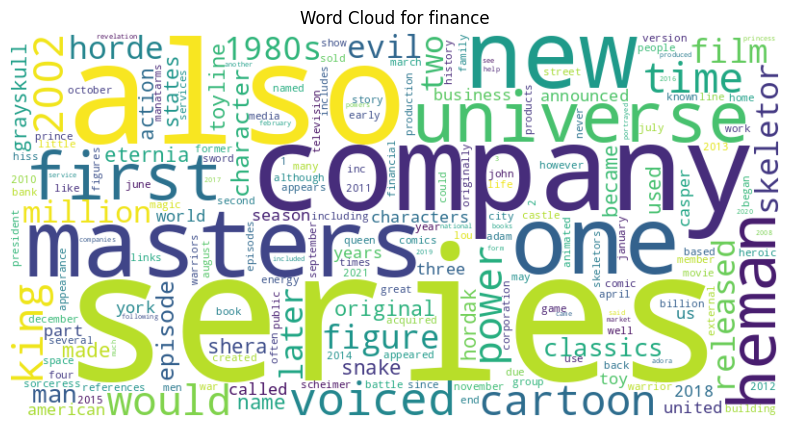

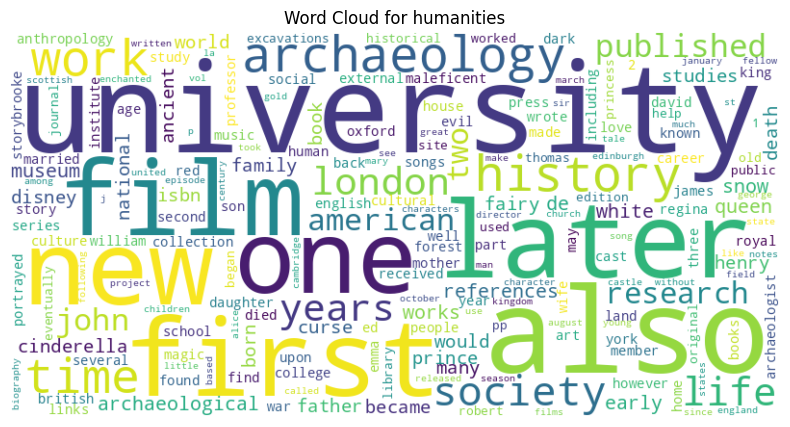

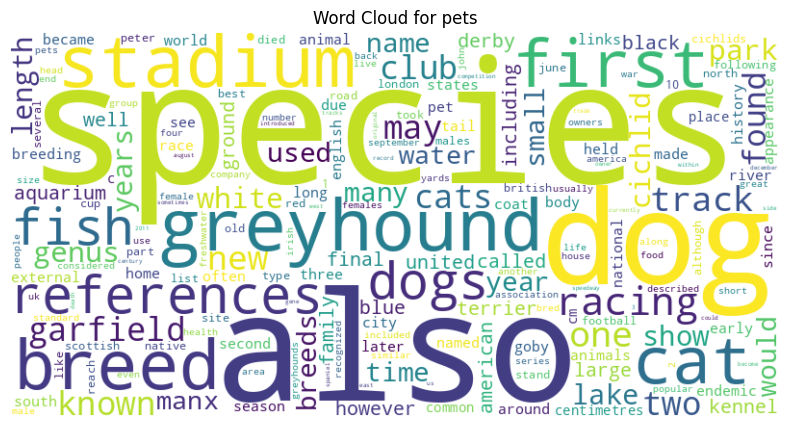

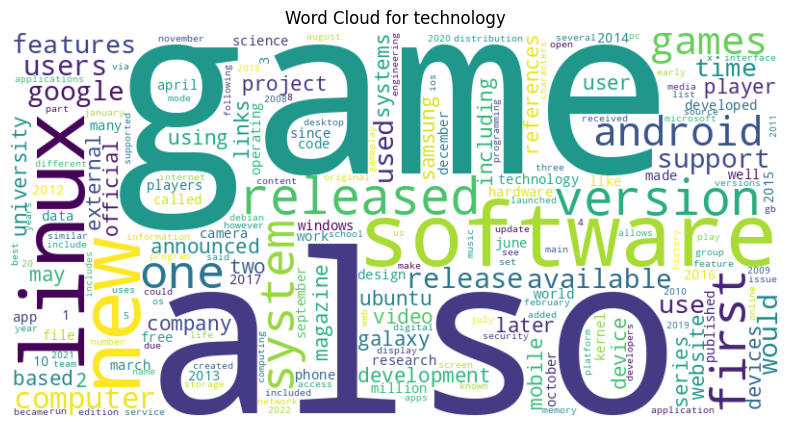

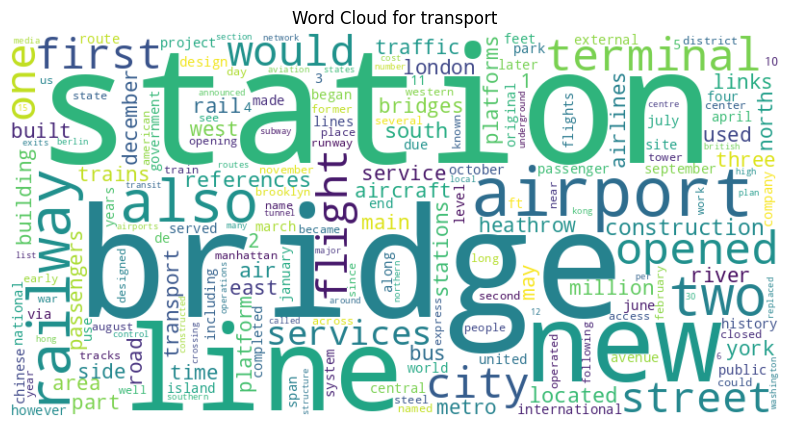

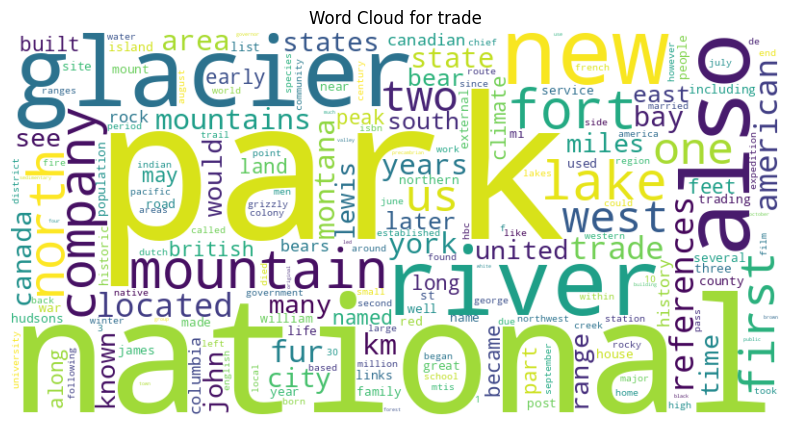

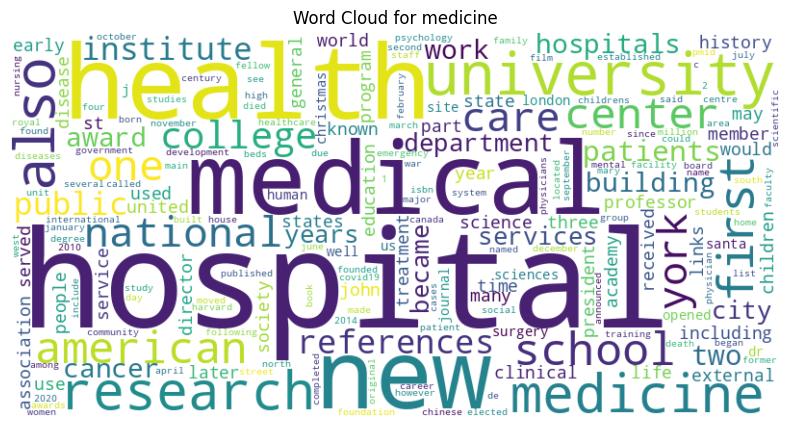

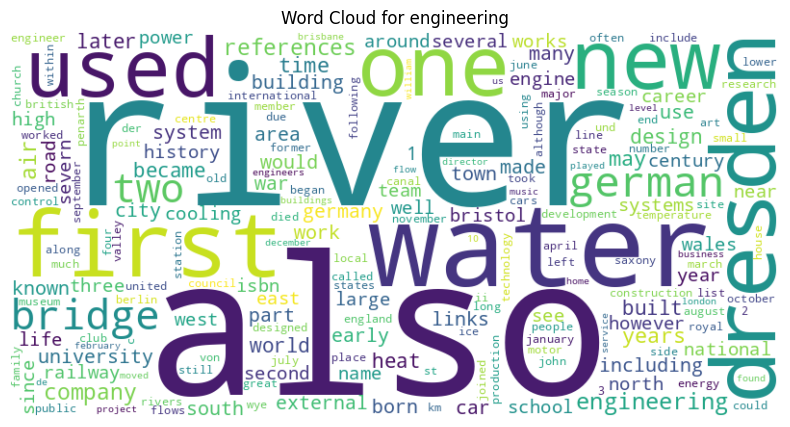

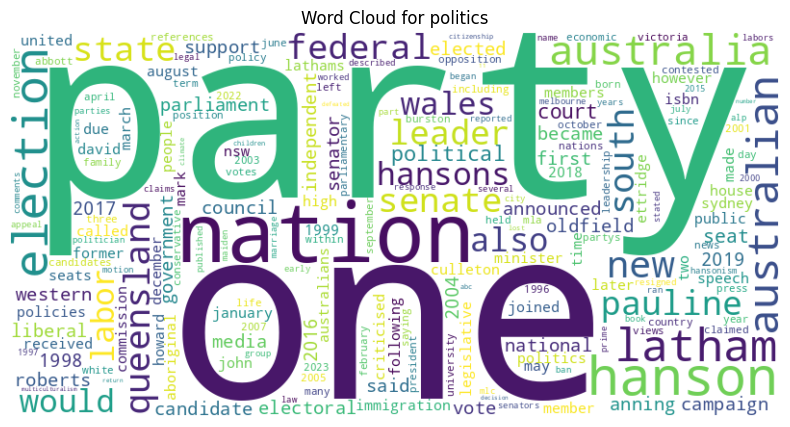

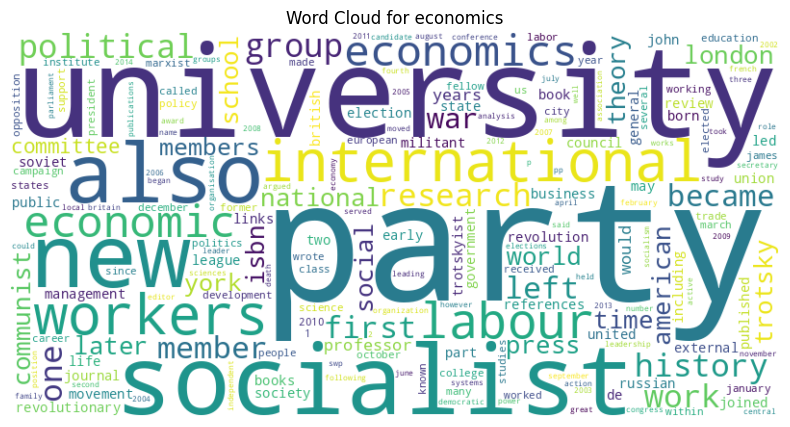

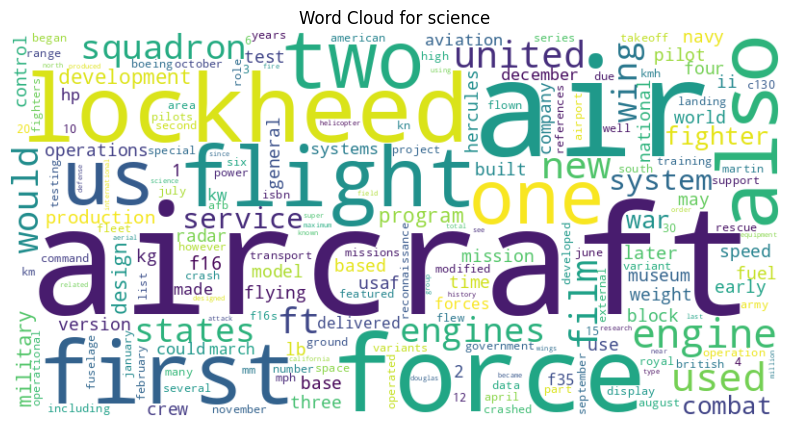

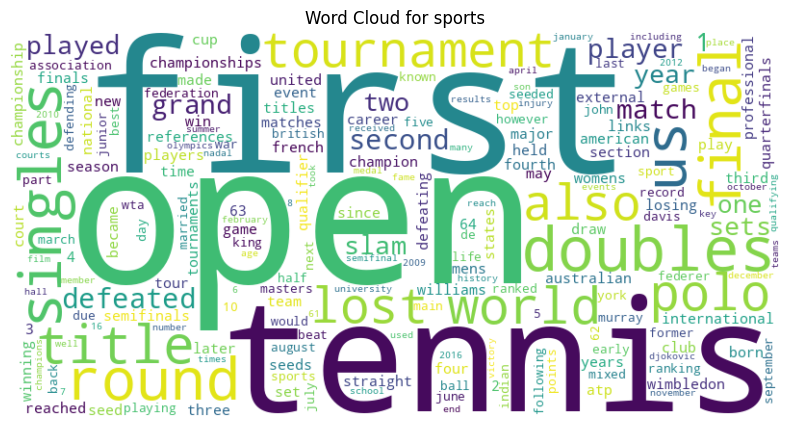

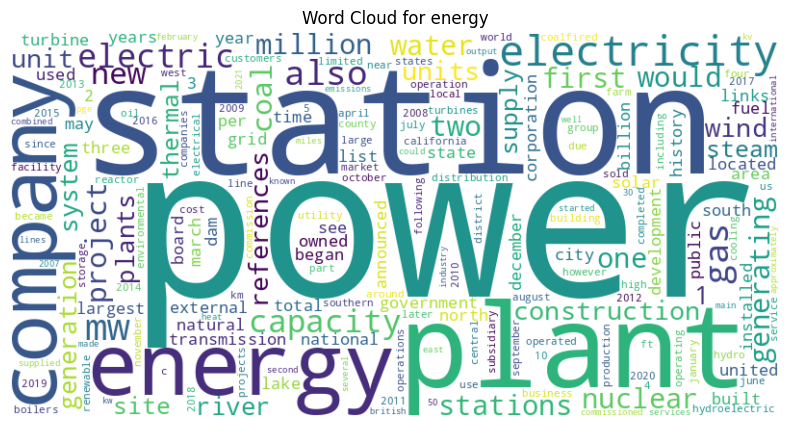

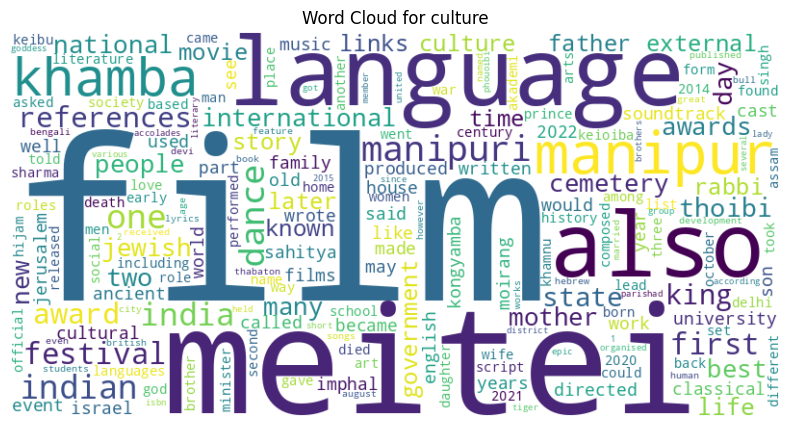

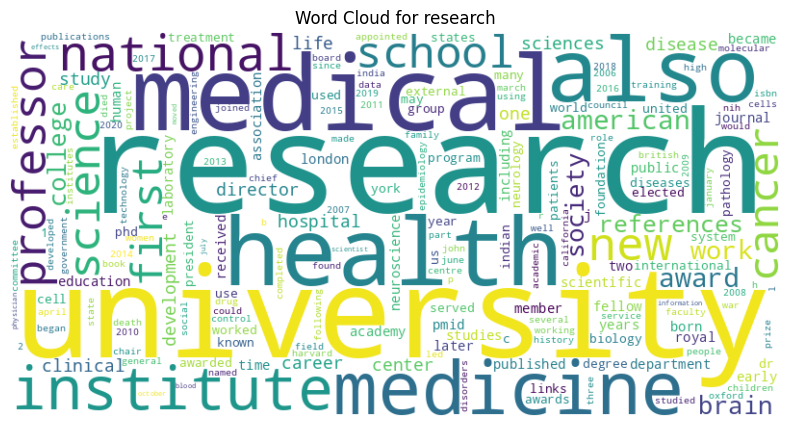

In [0]:
# Scaricare le stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Inizializza una sessione Spark
spark = SparkSession.builder.appName("WordCloudByCategory").getOrCreate()

# Carica il dataset dalla tabella Spark
df = spark.read.table('default.wikipedia')

# Filtra le colonne necessarie e pulisci il testo
df = df.select('categoria', lower(col('documents')).alias('documents'))

# Rimuovi la punteggiatura e tokenizza il testo in parole
df_cleaned = df.withColumn('documents', regexp_replace(col('documents'), '[^\w\s]', ''))
df_words = df_cleaned.withColumn('word', explode(split(col('documents'), r'\s+')))

# Rimuovi le stop words
df_filtered = df_words.filter(~col('word').isin(stop_words))

# Calcola la frequenza delle parole per categoria
df_word_count = df_filtered.groupBy('categoria', 'word').count()

# Converte il DataFrame Spark in Pandas per la visualizzazione delle nuvole di parole
categories = df_word_count.select('categoria').distinct().collect()

for category_row in categories:
    category = category_row['categoria']
    df_category = df_word_count.filter(col('categoria') == category).toPandas()

    # Genera la nuvola di parole
    word_freq = dict(zip(df_category['word'], df_category['count']))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    # Visualizza la nuvola di parole
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {category}')
    plt.axis('off')
    plt.show()

* Dopo aver svolto l’analisi richiesta, è necessario addestrare e testare un classificatore testuale capace di classificare gli articoli (secondo le categorie presenti nel dataset) che saranno in futuro inseriti, 

In [0]:
# Definizione delle stopwords e delle altre configurazioni per la pulizia del testo
english_stopwords = stopwords.words('english')
english_stopwords.extend(['from', 'subject', 're', 'edu', 'use'])
nlp = spacy.load('en_core_web_sm')
punctuation = set(string.punctuation)

def data_cleaner(sentence):
    if sentence is None or sentence.strip() == "":
        return ""
    sentence = sentence.lower()
    for c in string.punctuation:
        sentence = sentence.replace(c, " ")
    document = nlp(sentence)
    sentence = ' '.join(token.lemma_ for token in document)
    sentence = ' '.join(word for word in sentence.split() if word not in english_stopwords)
    sentence = re.sub('\d', '', sentence)
    sentence = re.sub(' +', " ", sentence)
    return sentence

# Definisce una funzione UDF per la pulizia del testo
clean_text_udf = udf(data_cleaner, StringType())


In [0]:
# Inizializza una sessione Spark
spark = SparkSession.builder.appName("TextClassification").getOrCreate()

# Carica il dataset dalla tabella Spark
df = spark.read.table('default.wikipedia')

# Filtra i record con testo nullo e vuoto
df_filtered_summary = df.filter((col('summary').isNotNull()) & (col('summary') != ""))
df_filtered_documents = df.filter((col('documents').isNotNull()) & (col('documents') != ""))

# Pulizia del testo
df_cleaned_summary = df_filtered_summary.select('categoria', clean_text_udf(col('summary')).alias('text'))
df_cleaned_documents = df_filtered_documents.select('categoria', clean_text_udf(col('documents')).alias('text'))


In [0]:
def build_pipeline():
    # Tokenizza il testo
    tokenizer = Tokenizer(inputCol="text", outputCol="words")
    
    # Rimuove le stop words
    remover = StopWordsRemover(inputCol="words", outputCol="filtered")
    
    # Costruisce il vettore di caratteristiche (Bag of Words)
    vectorizer = CountVectorizer(inputCol="filtered", outputCol="raw_features")
    
    # Applica TF-IDF
    idf = IDF(inputCol="raw_features", outputCol="features")
    
    # Converte le etichette di categoria in indici
    label_indexer = StringIndexer(inputCol="categoria", outputCol="label")
    
    # Modello di classificazione
    classifier = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)
    
    # Costruisce la pipeline
    pipeline = Pipeline(stages=[tokenizer, remover, vectorizer, idf, label_indexer, classifier])
    
    return pipeline


In [0]:
def train_and_evaluate(df_cleaned):
    # Costruisce la pipeline
    pipeline = build_pipeline()
    
    # Divide il dataset in training e test set
    train_data, test_data = df_cleaned.randomSplit([0.8, 0.2], seed=1234)
    
    # Addestra il modello
    model = pipeline.fit(train_data)
    
    # Effettua le previsioni sul test set
    predictions = model.transform(test_data)
    
    # Valuta il modello
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    
    return accuracy

In [0]:
# Addestramento e valutazione utilizzando la colonna "summary"
accuracy_summary = train_and_evaluate(df_cleaned_summary)
print(f"Accuracy using summary: {accuracy_summary}")


Accuracy using summary: 0.9500214996857739


In [0]:
# Addestramento e valutazione utilizzando la colonna "documents"
accuracy_documents = train_and_evaluate(df_cleaned_documents)
print(f"Accuracy using documents: {accuracy_documents}")

Come si può notare dai risultati differenti non c'è molta differenza in termini di accuratezza nella classificazione di documenti usando l intero documento o solo il suo stesso summary, anzi i risultati sembrano essere anche migliori (dico sembra perchè questa è sono un'analisi iniziale, per esempio per aumentarne l affidabilità si poteva usare il metodo della k fold crsoss validation il quale non è stato usato per motivi di tempo di calcolo), di conseguenza se l'obiettivo è solo quello di classificare il documento il dataframe potrebbe essere costruito tralasciando la colonna documents, il che porterebbe a un considerevole risparmio di memoria.